# I. Intro to LightGBM


In [1]:
import gc
import os
import math
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns

# Fifa Dataset

In [2]:
df = pd.read_csv('data/fifa.csv', index_col = 'Unnamed: 0')

In [3]:
df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


We come back to the previous FiFa dataset, to compare the efficiency between Deep Learning (Keras) and Tree-based models (LightGBM)

### Objective: Predict `Overall`

**Exercise**: Do data treatment with Pandas

In [6]:
# First clean columns where all value are na to avoid drop all df
df_clean = df.drop(columns=['Flag', 'Photo', 'Club Logo'])
df_clean = df_clean.dropna(axis=1, how='any')
df_clean

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,238813,J. Lundstram,19,England,47,65,Crewe Alexandra,€60K,€1K,1307,...,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,243165,N. Christoffersson,19,Sweden,47,63,Trelleborgs FF,€60K,€1K,1098,...,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,241638,B. Worman,16,England,47,67,Cambridge United,€60K,€1K,1189,...,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,246268,D. Walker-Rice,17,England,47,66,Tranmere Rovers,€60K,€1K,1228,...,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


In [16]:
for y in df_clean.columns:
    if not (df_clean[y].dtype == np.float64 or df_clean[y].dtype == np.int64):
        try:
            df_clean[y] = pd.to_numeric(df_clean[y])
            print(f'{y} column type has been changed to {df_clean[y].dtype}')
        except ValueError as e:
            # Drop column that could not be parse
            df_clean = df_clean.drop(columns=[y])
            print('error: ', e)
            print(f'{y} columns has been removed')
            
df_clean.columns

error:  Unable to parse string "L. Messi" at position 0
Name columns has been removed
error:  Unable to parse string "Argentina" at position 0
Nationality columns has been removed
error:  Unable to parse string "FC Barcelona" at position 0
Club columns has been removed
error:  Unable to parse string "€110.5M" at position 0
Value columns has been removed
error:  Unable to parse string "€565K" at position 0
Wage columns has been removed
error:  Unable to parse string "Left" at position 0
Preferred Foot columns has been removed
error:  Unable to parse string "Medium/ Medium" at position 0
Work Rate columns has been removed
error:  Unable to parse string "Messi" at position 0
Body Type columns has been removed
error:  Unable to parse string "Yes" at position 0
Real Face columns has been removed
error:  Unable to parse string "RF" at position 0
Position columns has been removed
error:  Unable to parse string "Jul 1, 2004" at position 0
Joined columns has been removed
error:  Unable to parse

**Exercise:** Do some plots with Matplotlib

(array([ 192.,  998., 2363., 4727., 4289., 3570., 1513.,  445.,   96.,
          14.]),
 array([46. , 50.8, 55.6, 60.4, 65.2, 70. , 74.8, 79.6, 84.4, 89.2, 94. ]),
 <a list of 10 Patch objects>)

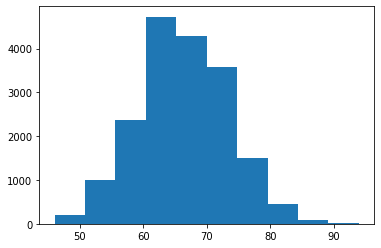

In [17]:
plt.hist(df_clean["Overall"])

**Exercise**: Split train/test randomly 80/20, train LightGBM (removing `potential`) and plot feature-importance

Note: to train regression, you need to use `lgb.LGBMRegressor` instead of `lgb.LGBMClassifier`. Don't forget to change the metrics and eval metrics

In [18]:
X = df_clean.copy()
y = X.Overall
X = X.drop(columns=["Overall", "Potential"])
X.head()

,ID,Age,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,HeadingAccuracy,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,158023,31,2202,5.0,4.0,4.0,10.0,84.0,95.0,70.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,20801,33,2228,5.0,4.0,5.0,7.0,84.0,94.0,89.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,190871,26,2143,5.0,5.0,5.0,10.0,79.0,87.0,62.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,193080,27,1471,4.0,3.0,1.0,1.0,17.0,13.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,192985,27,2281,4.0,5.0,4.0,7.0,93.0,82.0,55.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [20]:
def plot_feature_importance(feature_importance,title):
    fe = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)
    fe['feature'] = fe.index
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=fe)
    plt.xticks([])
    plt.title(title)
    return

In [21]:
def train_lgb(X_train, X_valid, y_train, y_valid, params=None):

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc', 'binary_logloss'],
            verbose=1, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

In [22]:
def calc_accuracy(y_pred, y):
    return sum(y_pred == y)/len(y)

In [23]:
params = {
          'n_estimators': 500,  # Number of trees
          'num_leaves': 60,  # max number of leaves in tree
          'min_data_in_leaf': 2,
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting": "gbdt",
          "bagging_freq": 10,
          'num_threads': 8,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
          "metric": 'binary_logloss',
         }

In [24]:
y_pred_train, y_pred_test, feature_importance = train_lgb(X_train, X_test, y_train, y_test, params=params)

[1]	training's auc: 1	training's binary_logloss: -4.19308	valid_1's auc: 1	valid_1's binary_logloss: -4.19309
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 1	training's binary_logloss: -4.19308	valid_1's auc: 1	valid_1's binary_logloss: -4.19311
[3]	training's auc: 1	training's binary_logloss: -4.19307	valid_1's auc: 1	valid_1's binary_logloss: -4.19311
[4]	training's auc: 1	training's binary_logloss: -4.19306	valid_1's auc: 1	valid_1's binary_logloss: -4.19312
[5]	training's auc: 1	training's binary_logloss: -4.19305	valid_1's auc: 1	valid_1's binary_logloss: -4.1931
[6]	training's auc: 1	training's binary_logloss: -4.19303	valid_1's auc: 1	valid_1's binary_logloss: -4.1931
[7]	training's auc: 1	training's binary_logloss: -4.19302	valid_1's auc: 1	valid_1's binary_logloss: -4.1931
[8]	training's auc: 1	training's binary_logloss: -4.193	valid_1's auc: 1	valid_1's binary_logloss: -4.19309
[9]	training's auc: 1	training's binary_logloss: -4.19298	valid_

0.0
0.0


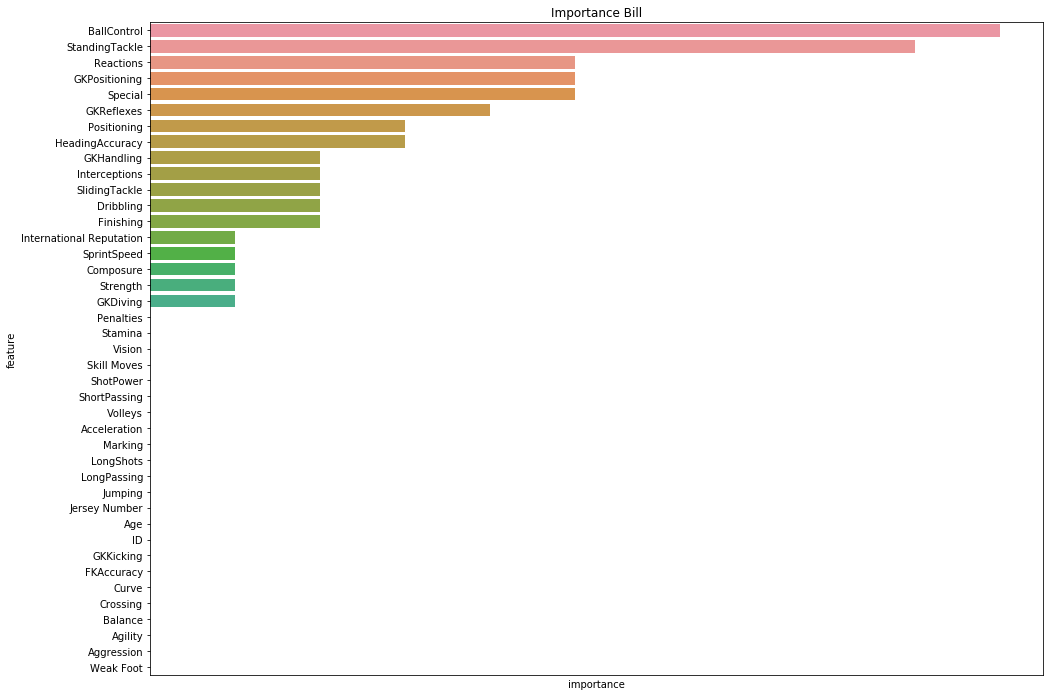

In [25]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))
plot_feature_importance(feature_importance, title = 'Importance FIFA')

**Exercise:** Try tuning, adding, removing params.
    
See https://lightgbm.readthedocs.io/en/latest/Parameters.html

**Exercise:** Try creating new features, or removing unimportant features

### Objective: Predict `Value`

**Exercise**: redo previous exercises to predict the value of a player